Tom Louwerse stores the raw simulation data that is used to produce the [Peilingwijzer](https://peilingwijzer.tomlouwerse.nl) in a file that can be downloaded via the following dynamic link:

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv("https://d1bjgq97if6urz.cloudfront.net/Public/Peilingwijzer/Last/coa_seats.csv",
                   index_col=0, header=0)

Colors picked from the Peilingwijzer's colors to make the correspondence clearer:

In [3]:
colors = {
    "VVD": "#455493",
    "PVV": "#00B9FF",
    "CDA": "#00894B",
    "D66": "#4AAB2D",
    "GL": "#006B39",
    "SP": "#C73D77",
    "PvdA": "#9A0D1B",
    "CU": "#0094B4",
    "PvdD": "#EBC30A",
    "50PLUS": "#C2791E",
    "SGP": "#7F8084",
    "Denk": "#41BAC1",
    "FvD": "#6E0C13",
    "PvdT": "#F9E518"
}

In [4]:
data.max().max()

46

In [5]:
hist_kwargs = dict(
#                alpha=0.8,
               stacked=True,
#                histtype='stepfilled',
#                density=True,
               figsize=(15,10)
)

<AxesSubplot:ylabel='Frequency'>

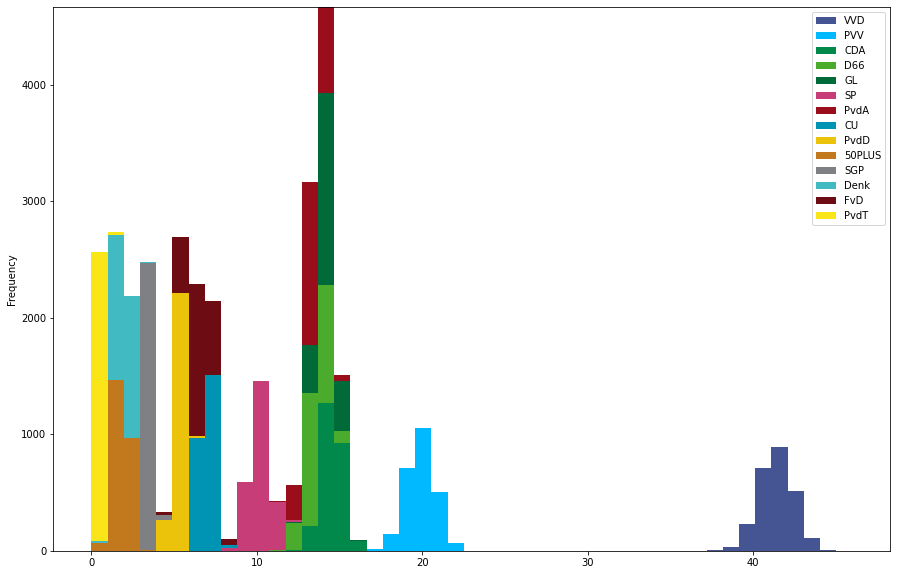

In [6]:
data.plot.hist(**hist_kwargs, bins=data.max().max() + 1, color=colors)

If you want to visualize coalitions in this way, you have to add up the counts per simulation and then visualize those numbers. For instance, let's take the VVD, PVV, CDA coalition, which at this point in time (10 November 2020) could form a majority, according to the sum of the polls' best estimates as published on the Peilingwijzer graph. And we compare to a huge left-wing-ish coalition.

In [7]:
coalitions = pd.DataFrame()

In [ ]:
def sum_coalition(data, *parties):
    return sum(data[party] for party in parties)

In [9]:
def add_coalition(coalitions_df, data, *parties, inplace=False):
    name = "+".join(parties)
    if not inplace:
        coalitions_df = coalitions_df.copy()
    coalitions_df[name] = sum_coalition(data, *parties)
    return coalitions_df

In [10]:
coalitions = add_coalition(coalitions, data, "VVD", "PVV", "CDA")

In [11]:
coalitions = add_coalition(coalitions, data, "GL", "SP", "PvdA", "PvdD", "Denk", "50PLUS")

In [12]:
coalitions

,VVD+PVV+CDA,GL+SP+PvdA+PvdD+Denk+50PLUS
result.1,77,44
result.2,74,47
result.3,76,44
result.4,73,47
result.5,73,46
...,...,...
result.2496,73,47
result.2497,73,47
result.2498,75,45
result.2499,75,45


<AxesSubplot:ylabel='Frequency'>

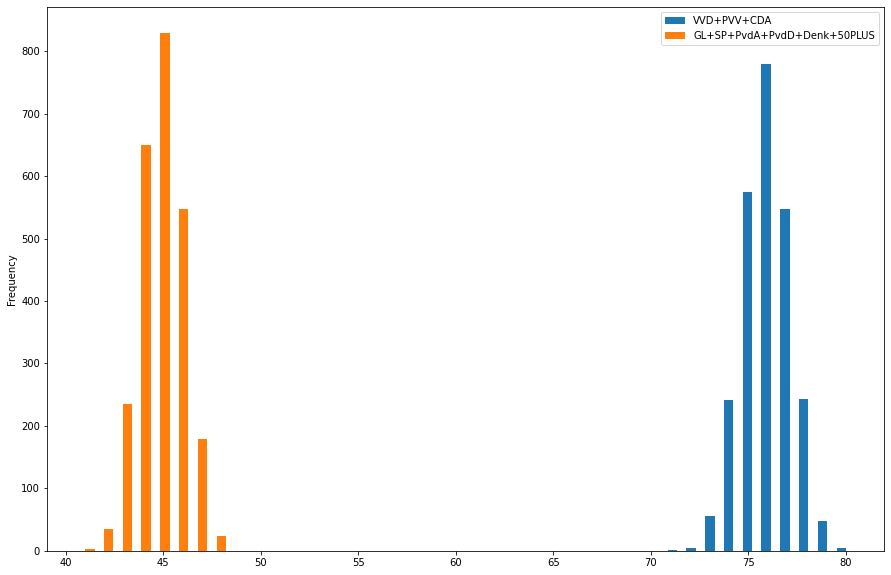

In [13]:
coalitions.plot.hist(
    **hist_kwargs,
    bins=coalitions.max().max() + 1
)

Now we have to still extract 95% confidence intervals. We can approximate by using mean and twice the standard deviation. Then round up, as is done in Peilingwijzer as well. Let's try it out for a few parties and see whether it matches.

In [14]:
import pickle
from collections import namedtuple
Peiling = namedtuple('Peiling', ['verwacht', 'laag', 'hoog'])
with open('peilingen.pkl', 'rb') as fh:
    numbers = pickle.load(fh)

In [15]:
import math

In [16]:
def compare_estimator_1(party):
    est = data[party].mean().round()
    interval = math.ceil((2 * data[party].std()))
    our_estimate = Peiling(verwacht=est, laag=max(0, est - interval), hoog=min(est + interval, 150))
    correct = numbers[party] == our_estimate
    return correct, {"correct": numbers[party], "ours": our_estimate, "mean": data[party].mean(), "2 x std": 2 * data[party].std()}

In [17]:
{party: compare_estimator_1(party) for party in data.columns}

{'VVD': (True,
  {'correct': Peiling(verwacht=42, laag=39, hoog=45),
   'ours': Peiling(verwacht=42.0, laag=39.0, hoog=45.0),
   'mean': 41.7928,
   '2 x std': 2.1621615612730745}),
 'PVV': (True,
  {'correct': Peiling(verwacht=20, laag=18, hoog=22),
   'ours': Peiling(verwacht=20.0, laag=18.0, hoog=22.0),
   'mean': 19.8356,
   '2 x std': 1.8444650662325432}),
 'CDA': (True,
  {'correct': Peiling(verwacht=14, laag=12, hoog=16),
   'ours': Peiling(verwacht=14.0, laag=12.0, hoog=16.0),
   'mean': 14.35,
   '2 x std': 1.3921117735570052}),
 'D66': (True,
  {'correct': Peiling(verwacht=13, laag=11, hoog=15),
   'ours': Peiling(verwacht=13.0, laag=11.0, hoog=15.0),
   'mean': 13.3936,
   '2 x std': 1.4473265221174694}),
 'GL': (False,
  {'correct': Peiling(verwacht=14, laag=13, hoog=15),
   'ours': Peiling(verwacht=14.0, laag=12.0, hoog=16.0),
   'mean': 14.0088,
   '2 x std': 1.1907381672530621}),
 'SP': (True,
  {'correct': Peiling(verwacht=10, laag=8, hoog=12),
   'ours': Peiling(verwac

Ok, not completely there yet, then, but pretty close. Had to add clip below 0 (and, to be technically correct, above 150).

But then still there's a few things going wrong:

- Denk is not at the mean. Is the peak instead determined at the maximum probability peak?
- GL, CU and 50PLUS have a broader confidence interval in our estimate. Perhaps ceil is not the best rounding function. We could fiddle a bit with a weird rounder that rounds up above 0.25 and down below that, or some other value that fits the distributions best.

This is probably all due to the gaussian approximation we make here. The actual model is not a Gaussian, so mean and std are flawed estimators of the true confidence interval. Anyway, as long as it's close, we can always try the actual model later.

Let's first try to compare max likelihood peak:

In [18]:
data["Denk"].value_counts().index[0]

1

In [19]:
def compare_estimator_2():
    comparison = {}

    def estimate_Peiling(est, std):
        interval = math.ceil((2 * std))
        return Peiling(verwacht=est, laag=max(0, est - interval), hoog=min(est + interval, 150))

    def check_correctness(theirs, ours):
        correct = theirs == ours
        return correct, {"correct": theirs,
                         "ours": ours,
                         "mean": data[party].mean(),
                         "2 x std": 2 * data[party].std()}

    def compare_party(party):
        est = data[party].value_counts().index[0]
        our_estimate = estimate_Peiling(est, data[party].std())
        return check_correctness(numbers[party], our_estimate)

    for party in data.columns:
        comparison[party] = compare_party(party)

    # add missing seats if necessary
    while sum(ding[1]['ours'].verwacht for ding in comparison.values()) < 150:
        rest_values = {party: thing[1]["mean"] - thing[1]["ours"].verwacht for party, thing in comparison.items()}
        party_max_rest = max(rest_values.keys(), key=(lambda k: rest_values[k]))

        ours_new = estimate_Peiling(comparison[party_max_rest][1]["ours"].verwacht + 1,
                                    comparison[party_max_rest][1]["2 x std"] / 2)

        comparison[party_max_rest] = check_correctness(numbers[party_max_rest], ours_new)

    return comparison

In [20]:
comparison_2 = compare_estimator_2()
# comparison_2
{party: ding[0] for party, ding in comparison_2.items()}

{'VVD': True,
 'PVV': True,
 'CDA': True,
 'D66': True,
 'GL': False,
 'SP': True,
 'PvdA': True,
 'CU': False,
 'PvdD': True,
 '50PLUS': False,
 'SGP': True,
 'Denk': False,
 'FvD': True,
 'PvdT': True}

In [21]:
sum(ding[1]['correct'].verwacht for ding in comparison_2.values())

150

In [22]:
sum(ding[1]['ours'].verwacht for ding in comparison_2.values())

150

Ah, ok, so Denk has to get a rest seat here, it seems.

Then, let's try the rounding fiddling to get the rest correct...

In [23]:
def compare_estimator_3(round_dec=0.15):
    comparison = {}

    def estimate_Peiling(est, std, round_dec=round_dec):
        two_std = 2 * std
        two_std_floor = math.floor(two_std)
        two_std_rest = two_std - two_std_floor
        if two_std_rest < round_dec:
            interval = two_std_floor
        else:
            interval = math.ceil(two_std)
        return Peiling(verwacht=est, laag=max(0, est - interval), hoog=min(est + interval, 150))

    def check_correctness(theirs, ours):
        correct = theirs == ours
        return correct, {"correct": theirs,
                         "ours": ours,
                         "mean": data[party].mean(),
                         "2 x std": 2 * data[party].std()}

    def compare_party(party):
        # max likelihood or mean makes no difference in practice
#         est = data[party].value_counts().index[0]
        est = data[party].mean().round()
        our_estimate = estimate_Peiling(est, data[party].std())
        return check_correctness(numbers[party], our_estimate)

    for party in data.columns:
        comparison[party] = compare_party(party)

    # add missing seats if necessary
    while sum(ding[1]['ours'].verwacht for ding in comparison.values()) < 150:
        rest_values = {party: thing[1]["mean"] - thing[1]["ours"].verwacht for party, thing in comparison.items()}
        party_max_rest = max(rest_values.keys(), key=(lambda k: rest_values[k]))

        ours_new = estimate_Peiling(comparison[party_max_rest][1]["ours"].verwacht + 1,
                                    comparison[party_max_rest][1]["2 x std"] / 2)

        comparison[party_max_rest] = check_correctness(numbers[party_max_rest], ours_new)

    return comparison

In [24]:
comparison_3 = compare_estimator_3()
{party: ding[0] for party, ding in comparison_3.items()}

{'VVD': True,
 'PVV': True,
 'CDA': True,
 'D66': True,
 'GL': False,
 'SP': True,
 'PvdA': True,
 'CU': True,
 'PvdD': True,
 '50PLUS': True,
 'SGP': True,
 'Denk': True,
 'FvD': True,
 'PvdT': True}

In [25]:
comparison_3['GL']

(False,
 {'correct': Peiling(verwacht=14, laag=13, hoog=15),
  'ours': Peiling(verwacht=14.0, laag=12.0, hoog=16.0),
  'mean': 14.0088,
  '2 x std': 1.1907381672530621})

Ok, so this is still not perfect, but it's the closest we can get, with only one wrong fit.

On the other hand, maybe just using the gaussian approximation with rounding up is a safer way to go. We will have some wider uncertainty estimates, but we can take those to represent the fact that we do not actually use the right model.

So, let's go with estimation method 2 for the coalitions. Except, instead of max likelihood, we go back to mean, because it makes no difference in practice, but is unambiguous in case there are two equally likely bins in the histogram.

Also, let's do it with Python standard library stuff now to prepare for using it from Heroku with minimal dependencies.

In [26]:
import statistics

In [96]:
def to_Peiling_from_simulations(simulations):
    def estimate_Peiling(est, std):
        interval = math.ceil((2 * std))
        return Peiling(verwacht=int(est),
                       laag=int(max(0, est - interval)),
                       hoog=int(min(est + interval, 150)))

    est = round(statistics.mean(simulations))
    return estimate_Peiling(est, statistics.stdev(simulations))

In [28]:
{party: to_Peiling_from_simulations(data[party]) == numbers[party] for party in data.columns}

{'VVD': True,
 'PVV': True,
 'CDA': True,
 'D66': True,
 'GL': False,
 'SP': True,
 'PvdA': True,
 'CU': False,
 'PvdD': True,
 '50PLUS': False,
 'SGP': True,
 'Denk': False,
 'FvD': True,
 'PvdT': True}

In [29]:
to_Peiling_from_simulations(coalitions["GL+SP+PvdA+PvdD+Denk+50PLUS"])

Peiling(verwacht=45, laag=42, hoog=48)

In [30]:
to_Peiling_from_simulations(coalitions["VVD+PVV+CDA"])

Peiling(verwacht=76, laag=73, hoog=79)

That was with a Pandas Series, but we can now also do it directly on a regular list:

In [31]:
to_Peiling_from_simulations(list(coalitions["VVD+PVV+CDA"]))

Peiling(verwacht=76, laag=73, hoog=79)

Now, when we do it for all parties, we should get a vanishing interval.

In [32]:
coalitions = add_coalition(coalitions, data, *data.columns)

In [33]:
coalitions.keys()

Index(['VVD+PVV+CDA', 'GL+SP+PvdA+PvdD+Denk+50PLUS',
       'VVD+PVV+CDA+D66+GL+SP+PvdA+CU+PvdD+50PLUS+SGP+Denk+FvD+PvdT'],
      dtype='object')

In [34]:
to_Peiling_from_simulations(list(coalitions["VVD+PVV+CDA+D66+GL+SP+PvdA+CU+PvdD+50PLUS+SGP+Denk+FvD+PvdT"]))

Peiling(verwacht=150, laag=150, hoog=150)

Cool!

In [35]:
to_Peiling_from_simulations(sum_coalition(data, *data.columns[:-1]))

Peiling(verwacht=150, laag=149, hoog=150)

Indeed, without PvdT (last in the list), which is estimated at 0, but could get 1, this is what you expect.

In [36]:
to_Peiling_from_simulations(sum_coalition(data, *data.columns[:-2]))

Peiling(verwacht=144, laag=142, hoog=146)

In [37]:
to_Peiling_from_simulations(data['FvD'])

Peiling(verwacht=6, laag=4, hoog=8)

FvD is second to last, so excluding it should indeed lower the estimate by 6. We see that the uncertainty of PvdT alone is no longer just "added" as we did before in the first Coalitiewijzer, but they are now combined into an uncertainty estimate that is apparently the same as that of FvD alone.

Time to build this into the Coalitiewijzer!

Save in native format:

In [38]:
import pickle

In [39]:
sims_df = pd.read_csv("https://d1bjgq97if6urz.cloudfront.net/Public/Peilingwijzer/Last/coa_seats.csv",
                       index_col=0, header=0)
sims = {party: tuple(sims_df[party]) for party in sims_df}

In [ ]:
with open('simulations.pkl', 'wb') as fh:
    pickle.dump(sims, fh)

In [40]:
import itertools

In [42]:
list(itertools.product('abcd'))

[('a',), ('b',), ('c',), ('d',)]

In [43]:
%pip install more-itertools

     |████████████████████████████████| 51kB 553kB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [48]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(len(s)+1))

In [49]:
import more_itertools

In [69]:
l = list(range(300))

In [70]:
%timeit more_itertools.powerset(l)
%timeit powerset(l)

1.52 µs ± 9.92 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
1.51 µs ± 16.2 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


Ok, so `more_itertools` is not necessary for just this function.

In [88]:
list(powerset(sims.keys()))[1]

('VVD',)

Use some adapted function versions for use with Python native objects:

In [101]:
def to_Peiling_from_simulations(simulations):
    def estimate_Peiling(est, std):
        interval = math.ceil((2 * std))
        return Peiling(verwacht=int(est),
                       laag=int(max(0, est - interval)),
                       hoog=int(min(est + interval, 150)))

    if simulations == 0 or len(simulations) == 0:
        return Peiling(0, 0, 0)
    est = round(statistics.mean(simulations))
    return estimate_Peiling(est, statistics.stdev(simulations))

In [104]:
%pip install tqdm

     |████████████████████████████████| 71kB 1.7MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [110]:
from tqdm.notebook import tqdm

In [111]:
table = {}
for key in tqdm(powerset(sims.keys()), total=2**len(sims.keys())):
    table[key] = to_Peiling_from_simulations(sum_coalition(sims, *key))

In [123]:
%timeit to_Peiling_from_simulations(sum_coalition(sims, *data.columns[:2]))

6.73 ms ± 31.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [122]:
%timeit table[tuple(data.columns[:2])]

4.08 µs ± 26.4 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


SO, retrieving from a precalculated table is over 1000 times faster. I guess that pays off in responsivity, so let's do that instead. Also saves imports (math & statistics) added in previous release.

In [125]:
with open('table.pkl', 'wb') as fh:
    pickle.dump(table, fh)

The size is quite substantial, 464 kb instead of 69 kb for the original simulations pickle file. Can we shrink this using numerical keys?

In [132]:
%timeit {b: a for a, b in enumerate(powerset(sims.keys()))}

2.67 ms ± 105 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [133]:
index = dict(enumerate(powerset(sims.keys())))

In [131]:
num_index = {b: a for a, b in enumerate(powerset(sims.keys()))}

In [134]:
num_table = {num_index[key]: value for key, value in table.items()}

In [136]:
with open('num_table.pkl', 'wb') as fh:
    pickle.dump(num_table, fh)

This is 240 kb.

In [138]:
%timeit num_table[num_index[tuple(data.columns[:2])]]

4.28 µs ± 160 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


Almost same speed as without the num-step in between.

ANYWAY, I may be over-engineering here.